In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!nvidia-smi

Mon Jun  8 15:21:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from glob import glob
import os, zipfile, cv2

import tensorflow.keras.layers as L
import tensorflow.keras as K
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [0]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 20
STEPS = 128
NUM_CLASSES = 20
DATASET_PATH = '/content/datasets/'

if not os.path.exists(DATASET_PATH):
    f = zipfile.ZipFile("/content/drive/My Drive/Colab Notebooks/catus_03.zip")
    f.extractall("./")

In [5]:
from tensorflow.keras.applications import DenseNet169

net = DenseNet169(include_top=False,
                  weights='imagenet',
                  input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

for layer in net.layers:
    layer.trainable = True

x = net.output
# BN-Relu
x = L.BatchNormalization()(x)
x = L.Activation('relu')(x)
x = L.GlobalMaxPooling2D()(x)
out = L.Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=net.input, outputs=out)

model.compile(loss= K.losses.CategoricalCrossentropy(), 
              optimizer= K.optimizers.Adam(amsgrad=True), 
              metrics= [K.metrics.CategoricalAccuracy()])

51879936/51877672 [==============================] - 1s 0us/step


In [6]:
trn_dagen = ImageDataGenerator(samplewise_center=True,
                               samplewise_std_normalization=True)

trn_gen = trn_dagen.flow_from_directory(DATASET_PATH + 'train',
                                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=True)

val_eva_dagen = ImageDataGenerator(samplewise_center=True,
                                   samplewise_std_normalization=True,
                                   validation_split=0.5)

val_gen = val_eva_dagen.flow_from_directory(DATASET_PATH + 'test',
                                            target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                            batch_size= BATCH_SIZE,
                                            class_mode='categorical',
                                            shuffle=True,
                                            subset='training')
                                            
eva_gen = val_eva_dagen.flow_from_directory(DATASET_PATH + 'test',
                                            target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                            batch_size= BATCH_SIZE * 10,
                                            class_mode='categorical',
                                            shuffle=True,
                                            subset='validation')

Found 4208 images belonging to 20 classes.
Found 705 images belonging to 20 classes.
Found 695 images belonging to 20 classes.


In [7]:
STEP_SIZE_TRAIN = trn_gen.n // BATCH_SIZE
STEP_SIZE_VALID = val_gen.n // BATCH_SIZE

history = model.fit(trn_gen,
                    steps_per_epoch= STEP_SIZE_TRAIN,
                    epochs= NUM_EPOCHS,
                    verbose= 1,
                    validation_data= val_gen,
                    validation_steps= STEP_SIZE_VALID)

Epoch 1/20
131/131 [==============================] - 37s 285ms/step - loss: 0.3303 - categorical_accuracy: 0.9330 - val_loss: 29.6059 - val_categorical_accuracy: 0.1648
Epoch 2/20
131/131 [==============================] - 34s 260ms/step - loss: 0.1626 - categorical_accuracy: 0.9610 - val_loss: 3.4652 - val_categorical_accuracy: 0.6435
Epoch 3/20
131/131 [==============================] - 34s 260ms/step - loss: 0.0475 - categorical_accuracy: 0.9878 - val_loss: 0.0900 - val_categorical_accuracy: 0.9716
Epoch 4/20
131/131 [==============================] - 34s 259ms/step - loss: 0.0135 - categorical_accuracy: 0.9966 - val_loss: 0.0175 - val_categorical_accuracy: 0.9957
Epoch 5/20
131/131 [==============================] - 34s 259ms/step - loss: 0.0331 - categorical_accuracy: 0.9916 - val_loss: 0.1761 - val_categorical_accuracy: 0.9588
Epoch 6/20
131/131 [==============================] - 34s 260ms/step - loss: 0.0317 - categorical_accuracy: 0.9914 - val_loss: 1.6886 - val_categorical_ac

In [8]:
loss, acc = model.evaluate(eva_gen, steps= len(eva_gen))
print('評估的準確率::  ', acc)

3/3 [==============================] - 1s 497ms/step - loss: 9.5135e-04 - categorical_accuracy: 1.0000
評估的準確率::   1.0


Text(0.5, 1.0, 'acc')

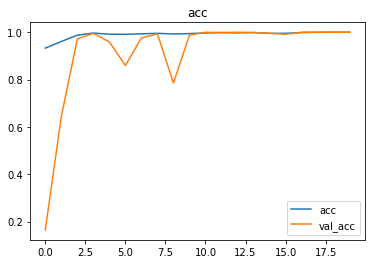

In [9]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.title('acc')

Text(0.5, 1.0, 'loss')

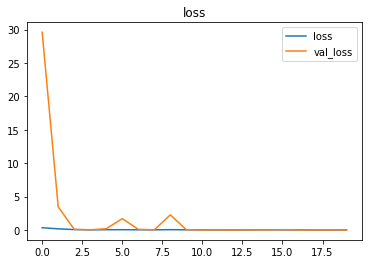

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

In [11]:
import pandas as pd
from sklearn.metrics import confusion_matrix

train, label = eva_gen.next()

pre = model.predict(train, steps= 1)
pre = pre.argmax(axis= -1)
label = label.argmax(axis= -1)

df = pd.DataFrame(confusion_matrix(label, pre))
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0


In [12]:
if not os.path.exists('simhei.zip'):
    !wget "https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip"
    !unzip "simhei.zip"
    !mv SimHei.ttf /usr/share/fonts/truetype/

import matplotlib.font_manager as fm

path = '/usr/share/fonts/truetype/SimHei.ttf'
fontprop = fm.FontProperties(fname=path, size=13)

--2020-06-08 15:34:12--  https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip
Resolving www.wfonts.com (www.wfonts.com)... 104.225.219.210
Connecting to www.wfonts.com (www.wfonts.com)|104.225.219.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10546298 (10M) [application/octetstream]
Saving to: ‘simhei.zip’

simhei.zip          100%[===================>]  10.06M  24.9MB/s    in 0.4s    

2020-06-08 15:34:13 (24.9 MB/s) - ‘simhei.zip’ saved [10546298/10546298]

Archive:  simhei.zip
  inflating: chinese.simhei.ttf      
  inflating: SimHei.ttf              
  inflating: sharefonts.net.txt      


In [13]:
trans = {
    0: '熊童子', 1: '心葉球蘭', 2: '八千代', 3: '乙女心', 4: '不死鳥', 
    5: '月兔耳', 6: '火祭', 7: '白鳥帽子', 8: '金鯱', 9: '金晃丸', 
    10: '紅蘋果椒草', 11: '虹之玉', 12: '桃太郎', 13: '野玫瑰之精', 14: '紫太陽', 
    15: '超太白十二之卷', 16: '綠珊瑚', 17: '銀之鈴', 18: '銀月', 19: '朧月'
}

idx = np.nonzero(pre != label)[0]
# 預測錯誤的圖
false_img = train[idx]
false_answer = label[idx]
false_predict = pre[idx]

# 把圖變大一點才塞的下

width = 8
height = len(false_img) // width + 1
plt.figure(figsize=(width * 2, height * 2.5))
for i, img in enumerate(false_img):
    plt.subplot(height, width, i+1)
    plt.axis("off")
    t = "[Ori]:{}\n[Pre]:{}".format(trans[false_answer[i]],
                                    trans[false_predict[i]])
    plt.title(t, fontproperties=fontprop)
    plt.imshow(img)

<Figure size 1152x180 with 0 Axes>